In [1]:
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import io

# Upload the file
uploaded = files.upload()

# Get the filename of the uploaded file
file_name = next(iter(uploaded))

# Read the Excel file
excel_file = pd.ExcelFile(io.BytesIO(uploaded[file_name]))

# Read the data from the Excel file
data = pd.read_excel(excel_file, header=0, index_col=0)

Saving 1_Average_strain_top_bending_nRMSE_final.xlsx to 1_Average_strain_top_bending_nRMSE_final.xlsx


In [2]:
# Transpose the data so that each row represents a configuration
X = data.T

# Rename columns to represent strain gauges
X.columns = [f'SG{i+1}' for i in np.arange(X.shape[1])]

# Convert data to numeric, replacing any non-numeric values with NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Remove any rows with NaN values
X = X.dropna()

combined_data = X

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [3]:
np.shape(X_scaled)

(3283, 26)

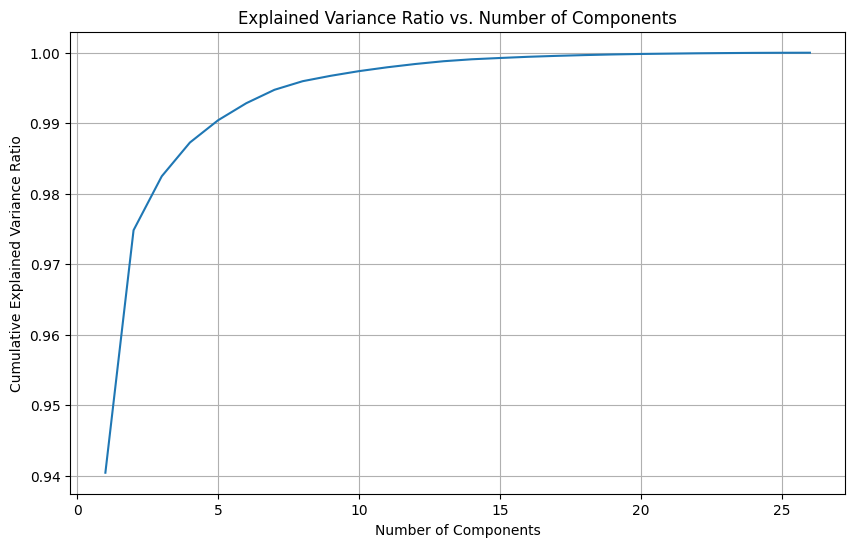

Measurement Point Importance:
           PC1       PC2       PC3       PC4       PC5
SG17  0.201714  0.007679  0.082793  0.039643  0.008845
SG23  0.201672  0.015724  0.071245  0.050881  0.045019
SG4   0.201379  0.010773  0.063188  0.116399  0.150403
SG10  0.201371  0.045152  0.083943  0.010568  0.012889
SG12  0.201343  0.008160  0.119696  0.059794  0.001173
SG11  0.201242  0.058088  0.148247  0.014239  0.035508
SG1   0.200932  0.029732  0.062382  0.085846  0.243521
SG2   0.200699  0.031676  0.037037  0.228887  0.072483
SG18  0.200514  0.098639  0.139292  0.000894  0.061221
SG24  0.200444  0.102921  0.139288  0.008721  0.066740
SG15  0.200413  0.044393  0.030057  0.209913  0.161244
SG6   0.200413  0.046453  0.123432  0.141974  0.088128
SG25  0.200384  0.056126  0.143380  0.147765  0.004743
SG21  0.200363  0.094168  0.024650  0.184806  0.182925
SG19  0.199738  0.066949  0.147233  0.214039  0.010979
SG5   0.199627  0.102200  0.191653  0.000548  0.018047
SG8   0.198902  0.141731  0.035999 

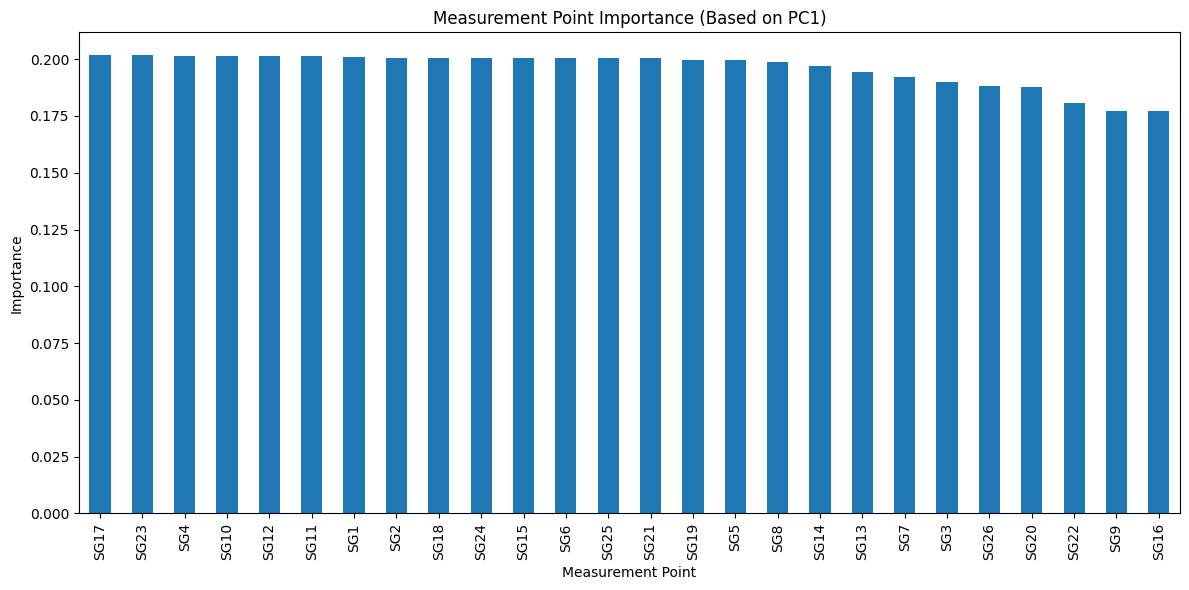

In [4]:
# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(X_scaled)

# Calculate the cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

# Analyzing Strain Gauge Importance
# Get the absolute values of the first few principal components
component_importance = np.abs(pca.components_[:5])  # Adjust the number of components as needed

# Create a DataFrame to store the importance of each measurement point
sg_importance = pd.DataFrame(
    component_importance.T,
    columns=[f'PC{i+1}' for i in np.arange(component_importance.shape[0])],
    index=[f'SG{i+1}' for i in np.arange(X.shape[1])]
)

# Sort measurement points by their importance in the first principal component
sg_importance_sorted = sg_importance.sort_values('PC1', ascending=False)

print("Measurement Point Importance:")
print(sg_importance_sorted)

# Visualize the importance of measurement points
plt.figure(figsize=(12, 6))
sg_importance_sorted['PC1'].plot(kind='bar')
plt.title('Measurement Point Importance (Based on PC1)')
plt.xlabel('Measurement Point')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [5]:
print("\n".join(f"{i}\t{var}" for i, var in zip(np.arange(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio)))


1	0.9404522247801516
2	0.9748349988041392
3	0.9824805898457717
4	0.9872701798670337
5	0.9904281000290948
6	0.9928437405239917
7	0.9947441454408933
8	0.9959625555157783
9	0.996732147907959
10	0.9973899598384502
11	0.9979356507973702
12	0.9984022873197903
13	0.998794496177786
14	0.9990706606372273
15	0.999252926596214
16	0.9994225823517782
17	0.9995535995418736
18	0.9996644087464732
19	0.999755412148011
20	0.9998249167207632
21	0.9998725391605641
22	0.9999190227504844
23	0.9999503521164427
24	0.99997742882421
25	0.9999927000614237
26	1.0


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Removing Redundant Measurement Points
# Set a threshold for cumulative explained variance
threshold = 0.99
n_components = np.argmax(cumulative_variance_ratio >= threshold) + 1

print(f"Number of components needed to explain {threshold*100}% of variance: {n_components}")

# Get the loadings for the retained components
loadings = pd.DataFrame(
    pca.components_[:n_components].T,
    columns=[f'PC{i+1}' for i in np.arange(n_components)],
    index=[f'SG{i+1}' for i in np.arange(X.shape[1])]
)

# Calculate the maximum absolute loading for each measurement point
max_loadings = loadings.abs().max(axis=1)

# Sort measurement points by their maximum loading
sorted_sg = max_loadings.sort_values(ascending=False)

print("\nMeasurement points sorted by importance:")
print(sorted_sg)

# Select the top N important strain gauges, where N is the number of components
important_sgs = sorted_sg.head(n_components).index.tolist()

print("\nImportant strain gauges:")
print(important_sgs)

# Calculate the cumulative importance of the selected strain gauges
selected_importance = sorted_sg.head(n_components).sum() / sorted_sg.sum()
print(f"\nCumulative importance of selected strain gauges: {selected_importance:.4f}")

Number of components needed to explain 99.0% of variance: 5

Measurement points sorted by importance:
SG9     0.715564
SG20    0.521015
SG16    0.481860
SG3     0.479244
SG22    0.446030
SG14    0.398090
SG26    0.311410
SG7     0.286548
SG1     0.243521
SG13    0.241965
SG2     0.228887
SG8     0.227044
SG19    0.214039
SG15    0.209913
SG17    0.201714
SG23    0.201672
SG4     0.201379
SG10    0.201371
SG12    0.201343
SG11    0.201242
SG18    0.200514
SG24    0.200444
SG6     0.200413
SG25    0.200384
SG21    0.200363
SG5     0.199627
dtype: float64

Important strain gauges:
['SG9', 'SG20', 'SG16', 'SG3', 'SG22']

Cumulative importance of selected strain gauges: 0.3565


In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import io

# Upload the file
uploaded = files.upload()

# Get the filename of the uploaded file
file_name = next(iter(uploaded))

# Read the Excel file
excel_file = pd.ExcelFile(io.BytesIO(uploaded[file_name]))

# Read the data from the Excel file
data = pd.read_excel(excel_file, header=0, index_col=0)

# Transpose the data so that each row represents a configuration
X = data.T

# Rename columns to represent strain gauges
X.columns = [f'SG{i+1}' for i in np.arange(X.shape[1])]

# Convert data to numeric, replacing any non-numeric values with NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Remove any rows with NaN values
X = X.dropna()

combined_data = X

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
np.shape(X_scaled)

Saving 2_Smoothed_BendingStrains_From_DIC_9cycles.xlsx to 2_Smoothed_BendingStrains_From_DIC_9cycles.xlsx


(4182, 26)

In [ ]:
# Prepare input (X) and target (y) data
X = combined_data[important_sgs]
y = combined_data.drop(columns=important_sgs)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)


# Create PyTorch datasets
class StrainDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = StrainDataset(X_train_scaled, y_train_scaled)
test_dataset = StrainDataset(X_test_scaled, y_test_scaled)

Epoch [1/50], Train Loss: 0.2267, Test Loss: 0.0184
Epoch [2/50], Train Loss: 0.0130, Test Loss: 0.0104
Epoch [3/50], Train Loss: 0.0082, Test Loss: 0.0073
Epoch [4/50], Train Loss: 0.0069, Test Loss: 0.0074
Epoch [5/50], Train Loss: 0.0064, Test Loss: 0.0063
Epoch [6/50], Train Loss: 0.0059, Test Loss: 0.0059
Epoch [7/50], Train Loss: 0.0056, Test Loss: 0.0058
Epoch [8/50], Train Loss: 0.0054, Test Loss: 0.0055
Epoch [9/50], Train Loss: 0.0052, Test Loss: 0.0053
Epoch [10/50], Train Loss: 0.0051, Test Loss: 0.0052
Epoch [11/50], Train Loss: 0.0050, Test Loss: 0.0050
Epoch [12/50], Train Loss: 0.0047, Test Loss: 0.0047
Epoch [13/50], Train Loss: 0.0047, Test Loss: 0.0049
Epoch [14/50], Train Loss: 0.0047, Test Loss: 0.0047
Epoch [15/50], Train Loss: 0.0047, Test Loss: 0.0044
Epoch [16/50], Train Loss: 0.0044, Test Loss: 0.0045
Epoch [17/50], Train Loss: 0.0046, Test Loss: 0.0043
Epoch [18/50], Train Loss: 0.0043, Test Loss: 0.0047
Epoch [19/50], Train Loss: 0.0044, Test Loss: 0.0041
Ep

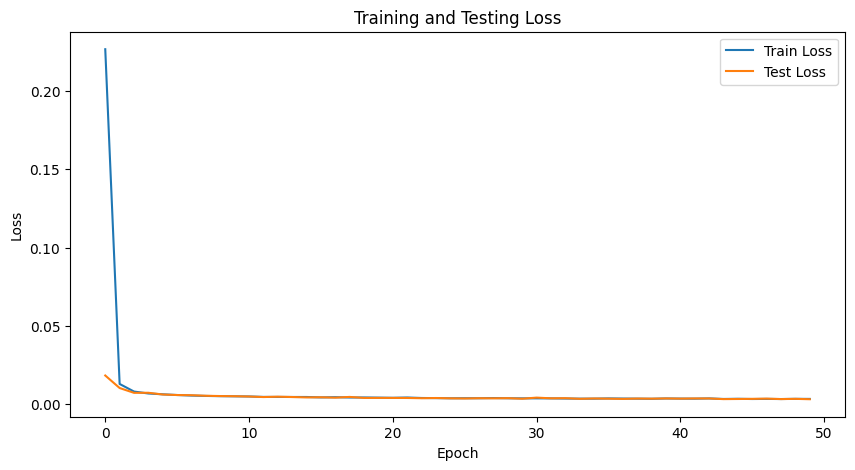

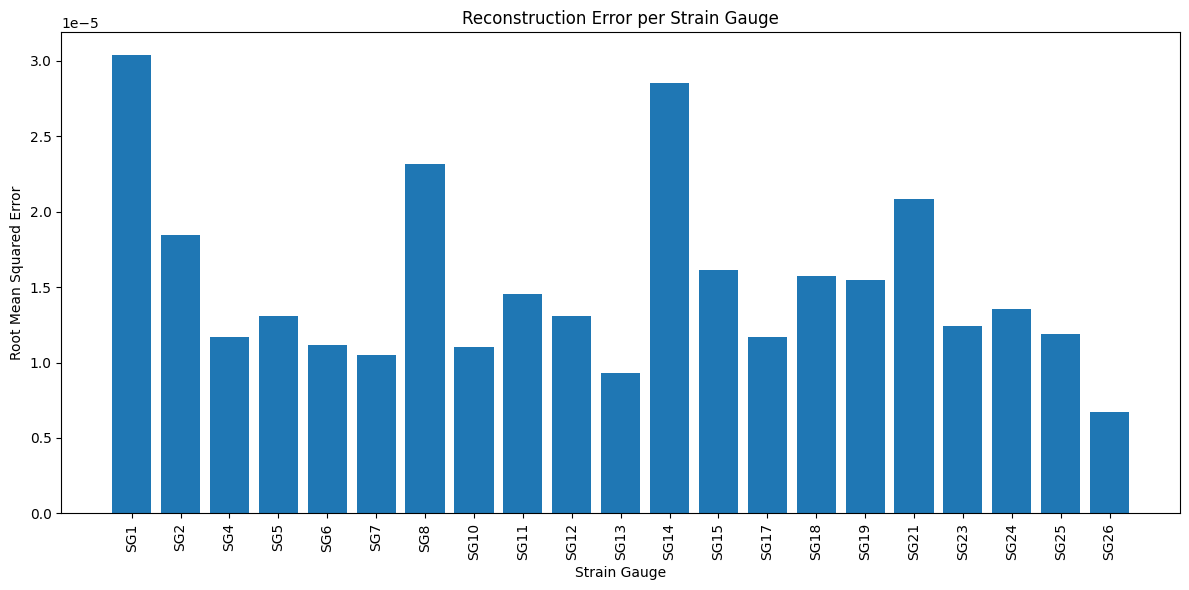

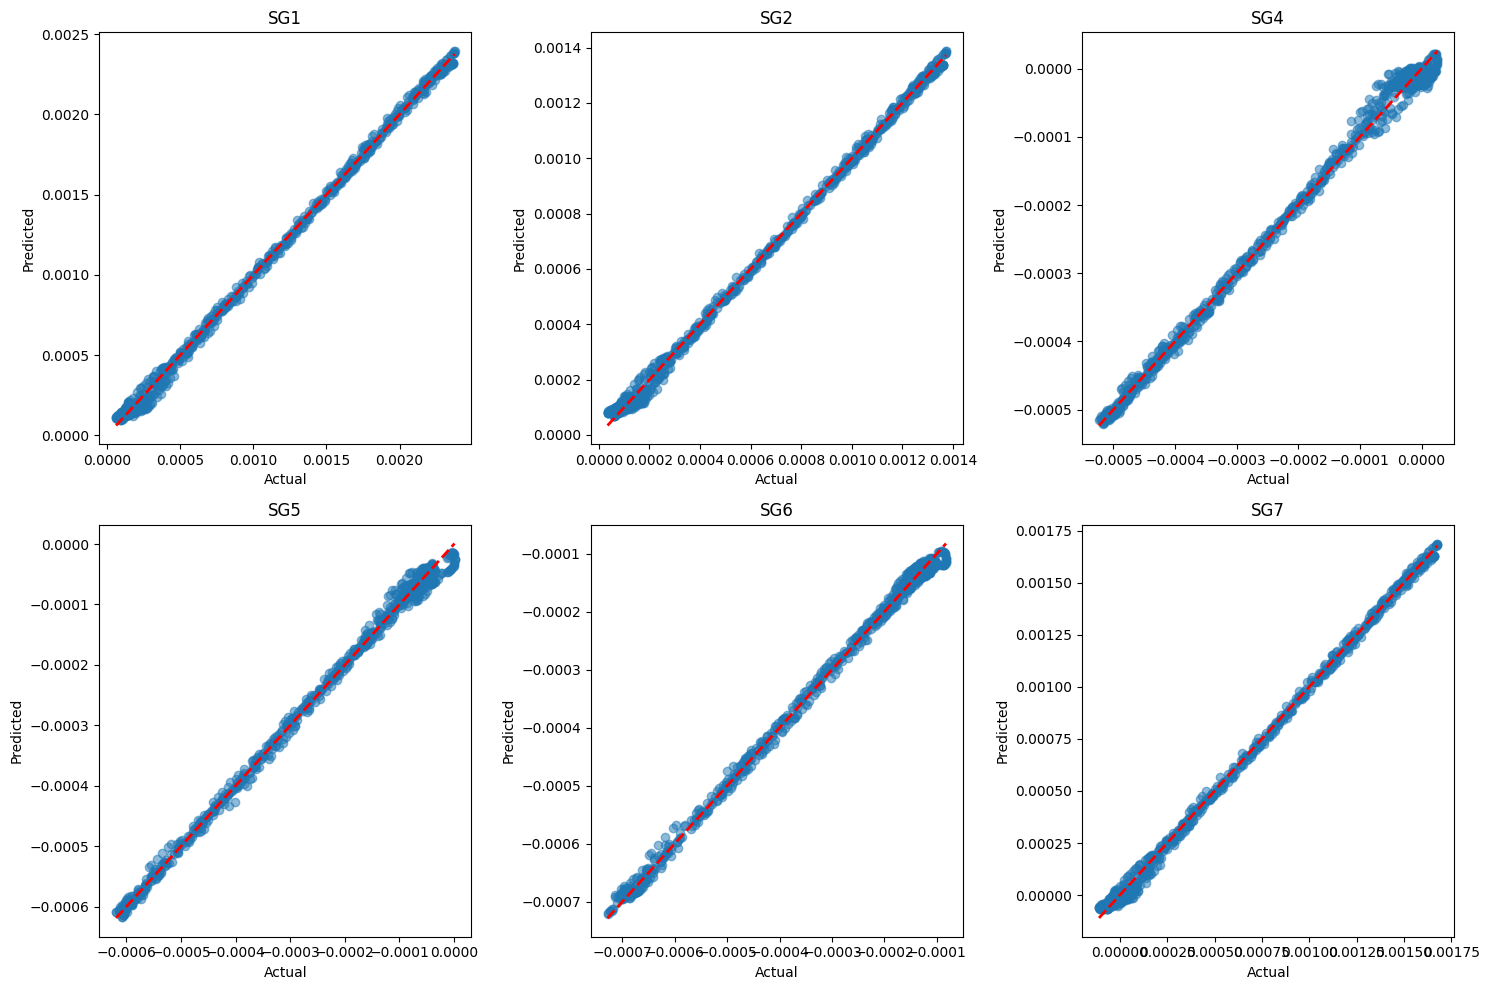

Model training and evaluation complete.


In [ ]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the model
class StrainFieldReconstructor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(StrainFieldReconstructor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.model(x)

# Initialize the model, loss function, and optimizer
model = StrainFieldReconstructor(input_size=len(important_sgs), hidden_size=64, output_size=y.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training loop
num_epochs = 50
train_losses = []
test_losses = []

for epoch in np.arange(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Evaluate on test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Plot training and testing loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.show()

# Evaluate the model on the test set
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        predictions.append(outputs.numpy())
        actuals.append(targets.numpy())

predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# Inverse transform the predictions and actuals
predictions_original = scaler_y.inverse_transform(predictions)
actuals_original = scaler_y.inverse_transform(actuals)

# Calculate MSE for each strain gauge
mse_per_sg = np.mean((predictions_original - actuals_original)**2, axis=0)

rmse_per_sg = np.sqrt(np.mean((predictions_original - actuals_original)**2, axis=0))

# Create a list of strain gauge names for the MSE values
output_sgs = [f'SG{i+1}' for i in np.arange(len(combined_data.columns)) if f'SG{i+1}' not in important_sgs]

# Plot MSE for each predicted strain gauge
plt.figure(figsize=(12, 6))
plt.bar(output_sgs, rmse_per_sg)
plt.xlabel('Strain Gauge')
plt.ylabel('Root Mean Squared Error')
plt.title('Reconstruction Error per Strain Gauge')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Visualize actual vs predicted for a few strain gauges, excluding important ones
output_sgs = [sg for sg in combined_data.columns if sg not in important_sgs]

num_plots = min(6, len(output_sgs))
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i in np.arange(num_plots):
    sg = output_sgs[i]
    sg_index = combined_data.columns.get_loc(sg)
    axes[i].scatter(actuals_original[:, sg_index], predictions_original[:, sg_index], alpha=0.5)
    axes[i].plot([actuals_original[:, sg_index].min(), actuals_original[:, sg_index].max()],
                 [actuals_original[:, sg_index].min(), actuals_original[:, sg_index].max()],
                 'r--', lw=2)
    axes[i].set_xlabel('Actual')
    axes[i].set_ylabel('Predicted')
    axes[i].set_title(sg)

# Remove any unused subplots
for i in np.arange(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


print("Model training and evaluation complete.")
torch.save(model.state_dict(), '1_Arduino_Bending_TopSurface.pth')




In [ ]:
with open('NN_Bending_Top_Surface.txt', 'w') as f:
    # Write metadata
    f.write(f"input_size,{len(important_sgs)}\n")
    f.write("hidden_size,64\n")
    f.write(f"output_size,{y.shape[1]}\n")

    # Iterate through layers and label weights/biases
    for i, param in enumerate(model.parameters()):
        if i % 2 == 0:
            # Even index: weights
            label = f"weight_{i // 2}"
        else:
            # Odd index: biases
            label = f"bias_{i // 2}"
        f.write(f"{label}\n")
        param_data = param.detach().numpy().ravel()
        for val in param_data:
            f.write(f"{val:.18e}\n")



In [ ]:
from google.colab import files
files.download('NN_Bending_Top_Surface.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
for sg, mse in zip(output_sgs, rmse_per_sg):
    print(f"{sg}\t{mse}")

SG1	3.178725819452666e-05
SG2	1.8264971004100516e-05
SG4	1.1772082871175371e-05
SG5	1.3282269719638862e-05
SG6	1.1585440006456338e-05
SG7	1.0006921002059244e-05
SG8	2.289685835421551e-05
SG10	1.089869601855753e-05
SG11	1.456193785998039e-05
SG12	1.34702486320748e-05
SG13	8.60940599523019e-06
SG14	2.7578051231103018e-05
SG15	1.6222684280364774e-05
SG17	1.1801439541159198e-05
SG18	1.6336418411810882e-05
SG19	1.6179013982764445e-05
SG21	2.1629364709951915e-05
SG23	1.2356740626273677e-05
SG24	1.3848576600139495e-05
SG25	1.2042697562719695e-05
SG26	6.979267254791921e-06


In [ ]:
# Find SG1's index in output strain gauges
sg1_index = output_sgs.index('SG1')

# Extract and save data
predicted_sg1 = predictions_original[:, sg1_index]
actual_sg1 = actuals_original[:, sg1_index]

np.savetxt('predicted_sg1.txt', predicted_sg1, fmt='%.6f')
np.savetxt('actual_sg1.txt', actual_sg1, fmt='%.6f')


In [ ]:
from google.colab import files
files.download('predicted_sg1.txt')
files.download('actual_sg1.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
np.shape(predictions_original)

(837, 21)

In [ ]:
import numpy as np

def calculate_rmse(predictions, actuals):
    return np.sqrt(np.mean((predictions - actuals) ** 2))
rmse = calculate_rmse(predictions_original, actuals_original)
print(f"RMSE: {rmse}")


RMSE: 1.6477608369314112e-05


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Print shapes of training and test data
print(f"Training data shape: {X_train_scaled.shape}")
print(f"Test data shape: {X_test_scaled.shape}")
print(f"Training output shape: {y_train_scaled.shape}")
print(f"Test output shape: {y_test_scaled.shape}")

# Calculate RMSE for each strain gauge
rmse_per_sg = np.sqrt(mean_squared_error(actuals_original, predictions_original, multioutput='raw_values'))

# Calculate overall RMSE
overall_rmse = np.sqrt(mean_squared_error(actuals_original, predictions_original))

# Create a list of strain gauge names, excluding the important ones
output_sgs = [f'SG{i+1}' for i in np.arange(len(combined_data.columns)) if f'SG{i+1}' not in important_sgs]


# Print RMSE for each predicted strain gauge
print("\nRMSE for each predicted strain gauge:")
for sg, rmse in zip(output_sgs, rmse_per_sg):
    print(f"{sg}: {rmse:.2e}")

print(f"\nOverall RMSE: {overall_rmse:.2e}")

Training data shape: (3345, 5)
Test data shape: (837, 5)
Training output shape: (3345, 21)
Test output shape: (837, 21)

RMSE for each predicted strain gauge:
SG1: 3.18e-05
SG2: 1.83e-05
SG4: 1.18e-05
SG5: 1.33e-05
SG6: 1.16e-05
SG7: 1.00e-05
SG8: 2.29e-05
SG10: 1.09e-05
SG11: 1.46e-05
SG12: 1.35e-05
SG13: 8.61e-06
SG14: 2.76e-05
SG15: 1.62e-05
SG17: 1.18e-05
SG18: 1.63e-05
SG19: 1.62e-05
SG21: 2.16e-05
SG23: 1.24e-05
SG24: 1.38e-05
SG25: 1.20e-05
SG26: 6.98e-06

Overall RMSE: 1.65e-05


In [ ]:
overall_min_test = X_test.min().min()
overall_max_test = X_test.max().max()
print(f"\nOverall range across all strain gauges in the test set: {overall_min_test:.6f} to {overall_max_test:.6f}")



Overall range across all strain gauges in the test set: -0.000498 to 0.000269


In [ ]:
range = overall_max_test - overall_min_test
rmse_percentage = (overall_rmse / range) * 100
print(f"\nRMSE as percentage of overall test range: {rmse_percentage:.2f}%")



RMSE as percentage of overall test range: 2.15%


In [ ]:
import numpy as np
from sklearn.metrics import r2_score

# Calculate R2 scores for each unknown strain gauge
r2_scores = []
for i in np.arange(predictions_original.shape[1]):
    r2 = r2_score(actuals_original[:, i], predictions_original[:, i])
    r2_scores.append(r2)

# Calculate the median and range of R2 scores
median_r2 = np.median(r2_scores)
range_r2 = (min(r2_scores), max(r2_scores))

print(f"Median R2 score: {median_r2:.4f}")
print(f"Range of R2 scores: ({range_r2[0]:.4f}, {range_r2[1]:.4f})")


Median R2 score: 0.9966
Range of R2 scores: (0.9916, 0.9986)


In [ ]:
import pandas as pd

# Assuming these variables are already calculated
data = {
    "Metric": [
        "Training data shape",
        "Test data shape",
        "Overall RMSE",
        "Overall range across all strain gauges in the test set",
        "RMSE as percentage of overall test range",
        "Median R2 score",
        "Range of R2 scores"
    ],
    "Value": [
        f"{X_train.shape}",
        f"{X_test.shape}",
        f"{overall_rmse:.6f}",
        f"{overall_min_test:.6f} to {overall_max_test:.6f}",
        f"{rmse_percentage:.2f}%",
        f"{median_r2:.2f}",
        f"({range_r2[0]:.2f}, {range_r2[1]:.2f})"
    ]
}

df = pd.DataFrame(data)

# Print the DataFrame in a tab-separated format
print(df.to_csv(sep='\t', index=False))


Metric	Value
Training data shape	(3345, 5)
Test data shape	(837, 5)
Overall RMSE	0.000016
Overall range across all strain gauges in the test set	-0.000498 to 0.000269
RMSE as percentage of overall test range	2.15%
Median R2 score	1.00
Range of R2 scores	(0.99, 1.00)



In [ ]:
# Upload the file
uploaded = files.upload()

# Get the filename of the uploaded file
file_name2 = next(iter(uploaded))

# Read the Excel file calculated_pca_sg_strains_validation.xlsx
data2 = pd.read_excel(io.BytesIO(uploaded[file_name2]), header=0, index_col=0)



StopIteration: 

In [ ]:
# Transpose the data so that each row represents a configuration
X_validation = data2.T

# Rename columns to represent strain gauges
X_validation_columns = [f'SG{i+1}' for i in np.arange(X_validation .shape[1])]

# Convert data to numeric, replacing any non-numeric values with NaN
X_validation  = X_validation .apply(pd.to_numeric, errors='coerce')

# Remove any rows with NaN values
X_validation  = X_validation .dropna()

combined_data_val = X_validation.copy()

In [ ]:
print(X_validation.columns)
print(np.shape(X_validation))

Index(['SG9', 'SG20', 'SG16', 'SG3', 'SG22', 'SG1', 'SG2', 'SG4', 'SG5', 'SG6',
       'SG7', 'SG8', 'SG10', 'SG11', 'SG12', 'SG13', 'SG14', 'SG15', 'SG17',
       'SG18', 'SG19', 'SG21', 'SG23', 'SG24', 'SG25', 'SG26'],
      dtype='object', name='StrainGauge')
(566, 26)


In [ ]:

X_validation  = combined_data_val[important_sgs]
y_validation  = combined_data_val.drop(columns=important_sgs)
print(np.shape(X_validation))
print(np.shape(y_validation))

(566, 5)
(566, 21)


In [ ]:
X_validation_scaled = scaler_X.transform(X_validation)

In [ ]:
y_validation_scaled = scaler_y.transform(y_validation)

In [ ]:
validation_dataset = StrainDataset(X_validation_scaled, y_validation_scaled)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [ ]:
# Evaluate the model on the validation set
model.eval()
predictions_val = []
actuals_val = []
with torch.no_grad():
    for inputs, targets in validation_loader:
        outputs = model(inputs)
        predictions_val.append(outputs.numpy())
        actuals_val.append(targets.numpy())

In [ ]:
predictions_val = np.concatenate(predictions_val)
actuals_val = np.concatenate(actuals_val)

# Inverse transform the predictions and actuals
predictions_original_val = scaler_y.inverse_transform(predictions_val)
actuals_original_val = scaler_y.inverse_transform(actuals_val)

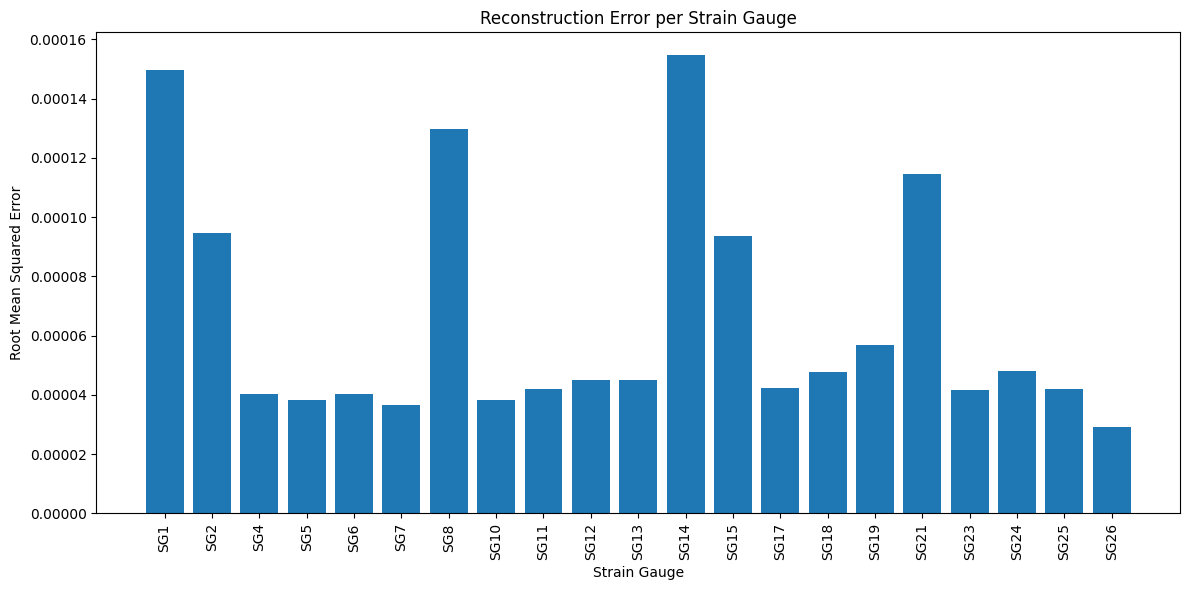

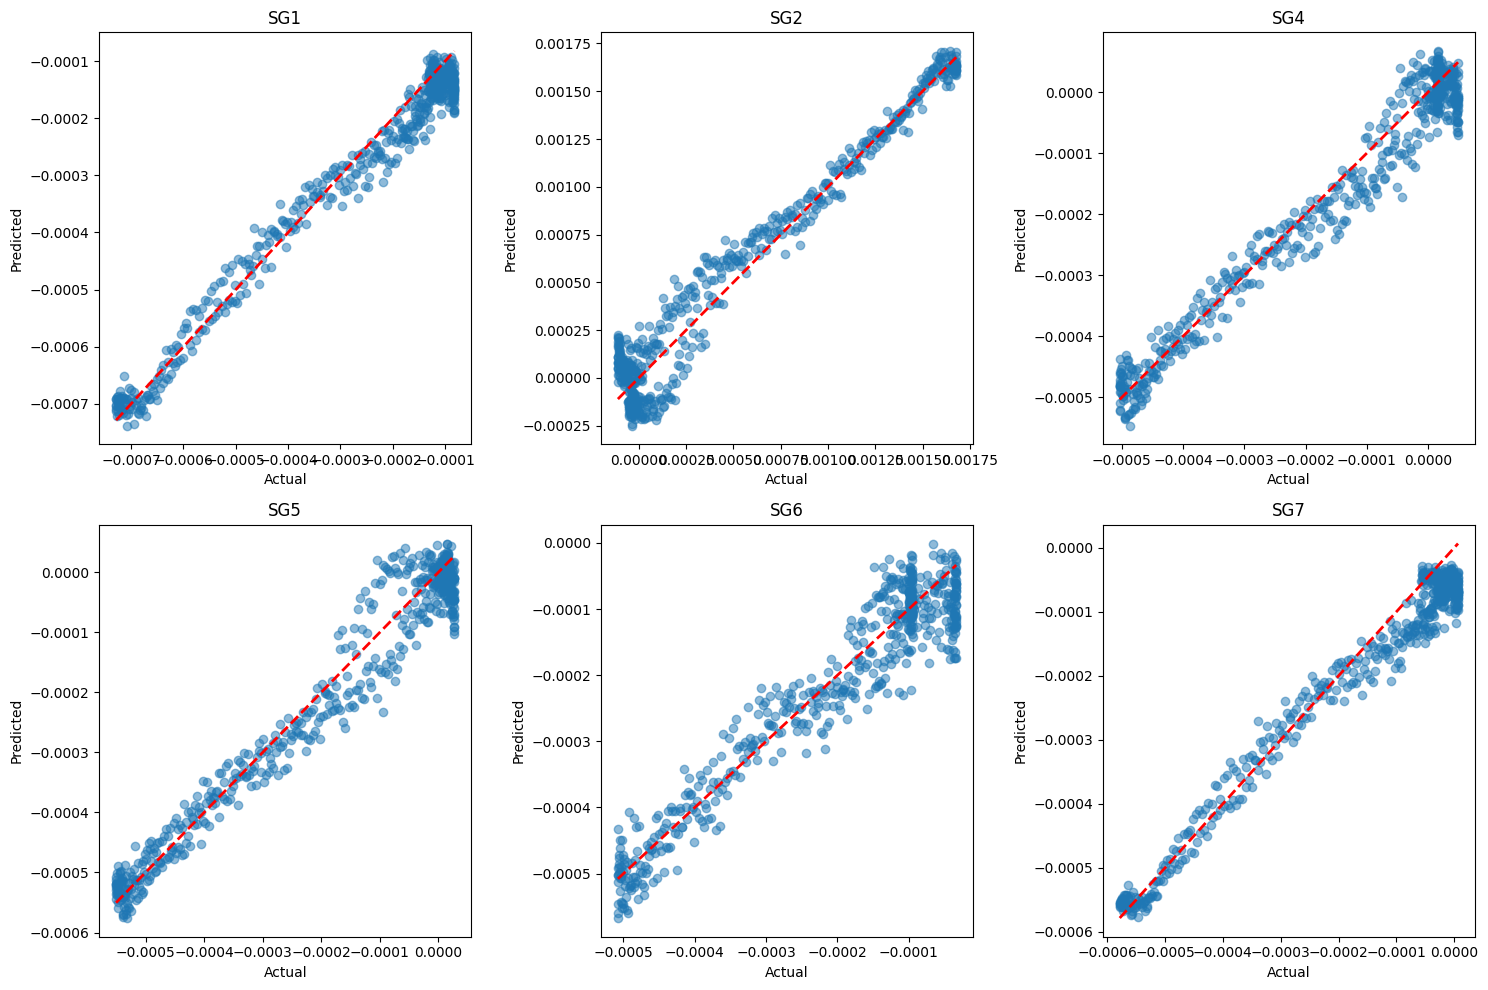

In [ ]:
# Calculate MSE for each strain gauge
mse_per_sg_val = np.mean((predictions_original_val - actuals_original_val)**2, axis=0)

rmse_per_sg_val = np.sqrt(np.mean((predictions_original_val - actuals_original_val)**2, axis=0))

# Create a list of strain gauge names for the MSE values
output_sgs_val = [f'SG{i+1}' for i in np.arange(len(combined_data_val.columns)) if f'SG{i+1}' not in important_sgs]

# Plot MSE for each predicted strain gauge
plt.figure(figsize=(12, 6))
plt.bar(output_sgs_val, rmse_per_sg_val)
plt.xlabel('Strain Gauge')
plt.ylabel('Root Mean Squared Error')
plt.title('Reconstruction Error per Strain Gauge')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Visualize actual vs predicted for a few strain gauges, excluding important ones
output_sgs_val = [sg for sg in combined_data_val.columns if sg not in important_sgs]

num_plots = min(6, len(output_sgs_val))
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i in np.arange(num_plots):
    sg = output_sgs_val[i]
    sg_index = combined_data_val.columns.get_loc(sg)
    axes[i].scatter(actuals_original_val[:, sg_index], predictions_original_val[:, sg_index], alpha=0.5)
    axes[i].plot([actuals_original_val[:, sg_index].min(), actuals_original_val[:, sg_index].max()],
                 [actuals_original_val[:, sg_index].min(), actuals_original_val[:, sg_index].max()],
                 'r--', lw=2)
    axes[i].set_xlabel('Actual')
    axes[i].set_ylabel('Predicted')
    axes[i].set_title(sg)

# Remove any unused subplots
for i in np.arange(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [ ]:
for sg, mse in zip(output_sgs_val, rmse_per_sg_val):
    print(f"{sg}\t{mse}")

SG1	0.00014972842473071069
SG2	9.45294086704962e-05
SG4	4.034480298287235e-05
SG5	3.8193164073163643e-05
SG6	4.035666279378347e-05
SG7	3.646852564997971e-05
SG8	0.00012979010352864861
SG10	3.8329286326188594e-05
SG11	4.198563328827731e-05
SG12	4.516188346315175e-05
SG13	4.4914188038092107e-05
SG14	0.0001546510902699083
SG15	9.37035511014983e-05
SG17	4.2359086364740506e-05
SG18	4.779489245265722e-05
SG19	5.7025361456908286e-05
SG21	0.00011464958515716717
SG23	4.1670828068163246e-05
SG24	4.810472091776319e-05
SG25	4.204130163998343e-05
SG26	2.9036484193056822e-05


In [ ]:
# Calculate overall RMSE
overall_rmse_val = np.sqrt(mean_squared_error(actuals_original_val, predictions_original_val))

# Create a list of strain gauge names, excluding the important ones
output_sgs = [f'SG{i+1}' for i in np.arange(len(combined_data.columns)) if f'SG{i+1}' not in important_sgs]


# Print RMSE for each predicted strain gauge
print("\nRMSE for each predicted strain gauge:")
for sg, rmse in zip(output_sgs, rmse_per_sg_val):
    print(f"{sg}: {rmse:.2e}")

print(f"\nOverall RMSE Val: {overall_rmse_val:.2e}")


RMSE for each predicted strain gauge:
SG1: 1.50e-04
SG2: 9.45e-05
SG4: 4.03e-05
SG5: 3.82e-05
SG6: 4.04e-05
SG7: 3.65e-05
SG8: 1.30e-04
SG10: 3.83e-05
SG11: 4.20e-05
SG12: 4.52e-05
SG13: 4.49e-05
SG14: 1.55e-04
SG15: 9.37e-05
SG17: 4.24e-05
SG18: 4.78e-05
SG19: 5.70e-05
SG21: 1.15e-04
SG23: 4.17e-05
SG24: 4.81e-05
SG25: 4.20e-05
SG26: 2.90e-05

Overall RMSE Val: 7.60e-05


In [ ]:
np.shape(predictions_original_val)

(566, 21)

In [ ]:
import numpy as np
from sklearn.metrics import r2_score

# Calculate R2 scores for each unknown strain gauge
r2_scores_val = []
for i in np.arange(predictions_original_val.shape[1]):
    r2_val = r2_score(actuals_original_val[:, i], predictions_original_val[:, i])
    r2_scores_val.append(r2_val)

# Calculate the median and range of R2 scores
median_r2_val = np.median(r2_scores_val)
range_r2_val = (min(r2_scores_val), max(r2_scores_val))

print(f"Median R2 score: {median_r2_val:.4f}")
print(f"Range of R2 scores: ({range_r2_val[0]:.4f}, {range_r2_val[1]:.4f})")

Median R2 score: 0.9582
Range of R2 scores: (0.8923, 0.9719)


In [ ]:
overall_min_val = X_validation.min().min()
overall_max_val = X_validation.max().max()
print(f"\nOverall range across all strain gauges in the test set: {overall_min_val:.6f} to {overall_max_val:.6f}")

range_val = overall_max_val - overall_min_val
rmse_percentage_val = (overall_rmse_val / range_val) * 100
print(f"\nRMSE as percentage of overall validation range: {rmse_percentage_val:.2f}%")


Overall range across all strain gauges in the test set: -0.000495 to 0.000291

RMSE as percentage of overall validation range: 9.66%
